In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, gc
import shap


In [5]:
data=pd.read_csv("application_train.csv")
print(data.shape)
data.info()

(33011, 122)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33011 entries, 0 to 33010
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(85), int64(21), object(16)
memory usage: 30.7+ MB


In [7]:
data.head()


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


TARGET
0    0.91936
1    0.08064
Name: proportion, dtype: float64


<Axes: xlabel='TARGET', ylabel='count'>

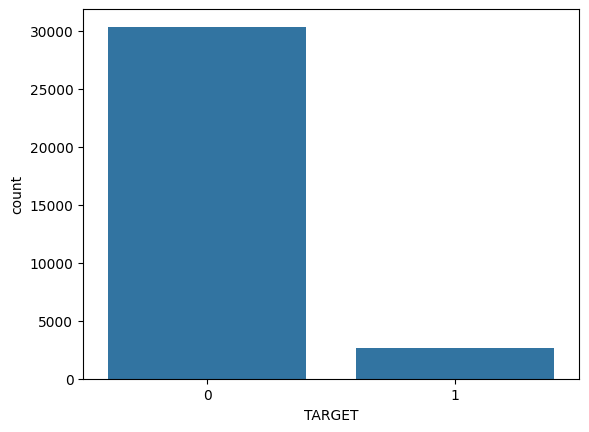

In [8]:
print(data['TARGET'].value_counts(normalize=True))
sns.countplot(x='TARGET', data=data)

In [11]:
data.isnull().sum()


,0
SK_ID_CURR,0
TARGET,0
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
...,...
AMT_REQ_CREDIT_BUREAU_DAY,4448
AMT_REQ_CREDIT_BUREAU_WEEK,4448
AMT_REQ_CREDIT_BUREAU_MON,4448
AMT_REQ_CREDIT_BUREAU_QRT,4448


In [20]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)


In [21]:
threshold=data.shape[0]*0.5
not_keep_features= data.columns[data.isnull().sum()>threshold]
print(not_keep_features.tolist())

keep_features= data.columns[data.isnull().sum()<threshold]
print(keep_features.tolist())



['OWN_CAR_AGE', 'EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE']
['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME

In [22]:
data_kept = data[keep_features]

num_cols = data_kept.select_dtypes(include=['number']).columns.tolist()
cat_cols = data_kept.select_dtypes(exclude=['number']).columns.tolist()

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)


Numeric columns: ['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'FLOORSMAX_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'FLOORSMAX_MEDI', 'TOTALAREA_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCU

In [23]:
data['INCOME_CREDIT_PERCENTAGE'] = data['AMT_INCOME_TOTAL'] / data['AMT_CREDIT']
data['ANNUL_LOAN_PAYMENT_PERCENTAGE'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
data['PAYMENT_RAET']= data['AMT_ANNUITY'] / data['AMT_CREDIT']


In [28]:
from sklearn.preprocessing import LabelEncoder
data_kept = data[keep_features].copy()


for col in cat_cols:
  data_kept[col] = data_kept[col].fillna('MISSING')

  if data_kept[col].nunique()<=50:
    le=LabelEncoder()
    data_kept[col]=le.fit_transform(data_kept[col])
  else:
    data_kept[col]=data_kept[col].astype('category').cat.codes



In [33]:
from sklearn.model_selection import train_test_split
x=data_kept.drop([ID, TARGET], axis=1)
y=data_kept[TARGET]

x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=0.2, stratify=y, random_state=42)

In [38]:
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

train_data=lgb.Dataset(x_train, label=y_train)
valid_data=lgb.Dataset(x_val, label=y_val, reference=train_data)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.02,
    'num_leaves': 15,
    'max_depth': 5,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l2': 1.0,
    'seed': 42,
    'verbose': -1
}


model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    num_boost_round=1000,
    callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=50)]
)

Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.751783	valid_1's auc: 0.736832
[100]	training's auc: 0.767909	valid_1's auc: 0.746769
[150]	training's auc: 0.783157	valid_1's auc: 0.75158
[200]	training's auc: 0.794732	valid_1's auc: 0.753891
[250]	training's auc: 0.805912	valid_1's auc: 0.755506
[300]	training's auc: 0.81623	valid_1's auc: 0.755497
Early stopping, best iteration is:
[265]	training's auc: 0.809507	valid_1's auc: 0.755859


In [40]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score

y_pred=model.predict(x_val)
print("AUC score is ", roc_auc_score(y_val,y_pred))

AUC score is  0.7558589275032418


In [42]:
prev_app=pd.read_csv("previous_application.csv")

num_cols = prev_app.select_dtypes(include=[np.number]).columns
num_cols = [col for col in num_cols if col not in ['SK_ID_PREV', 'SK_ID_CURR']]

prev_agg = prev_app.groupby('SK_ID_CURR')[num_cols].agg(['mean', 'max', 'min', 'sum', 'var'])

prev_agg.columns = [f"PREV_{col}_{stat}".upper() for col, stat in prev_agg.columns]

data_kept = data_kept.merge(prev_agg, on='SK_ID_CURR', how='left')




In [45]:
import pandas as pd
import numpy as np

bureau = pd.read_csv('bureau.csv')
bb = pd.read_csv('bureau_balance.csv')

bb_summary = bb.groupby('SK_ID_BUREAU').agg(
    BB_MIN_MONTH=('MONTHS_BALANCE', 'min'),
    BB_MAX_MONTH=('MONTHS_BALANCE', 'max'),
    BB_COUNT=('MONTHS_BALANCE', 'size')
).reset_index()

bureau = bureau.merge(bb_summary, on='SK_ID_BUREAU', how='left')

num_cols = [col for col in bureau.select_dtypes(include=[np.number]).columns
            if col not in ['SK_ID_BUREAU', 'SK_ID_CURR']]

bureau[num_cols] = bureau[num_cols].apply(pd.to_numeric, errors='coerce')

agg_funcs = {col: ['mean', 'sum', 'min', 'max', 'var'] for col in num_cols}
bureau_summary = bureau.groupby('SK_ID_CURR').agg(agg_funcs).reset_index()

bureau_summary.columns = [
    f"BUREAU_{col[0].upper()}_{col[1].upper()}" if col[1] else col[0]
    for col in bureau_summary.columns
]

data_kept = data_kept.merge(bureau_summary, on='SK_ID_CURR', how='left')


In [70]:
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import pandas as pd
import numpy as np

# Prepare for cross-validation
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_predictions = np.zeros(x.shape[0])  # Store predictions for each row
feature_importances = pd.DataFrame()

# Loop over each fold
for fold_num, (train_idx, valid_idx) in enumerate(folds.split(x, y), start=1):

    # Split into training and validation sets
    X_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = x.iloc[valid_idx], y.iloc[valid_idx]

    # Create LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)

    params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "num_leaves": 64,
    "max_depth": 8,
    "learning_rate": 0.01,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "min_data_in_leaf": 30,
    "lambda_l1": 0.1,
    "lambda_l2": 0.2,
    "random_state": 42,
    "verbosity": -1
    }


    # Train the model
    model = lgb.train(
        params,
        train_data,
        num_boost_round=10000,
        valid_sets=[train_data, valid_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=200),
            lgb.log_evaluation(period=200)
        ]
    )

    # Save predictions for the validation fold
    oof_predictions[valid_idx] = model.predict(X_valid, num_iteration=model.best_iteration)

    # Save feature importance for this fold
    fold_importance = pd.DataFrame({
        "feature": x.columns,
        "importance": model.feature_importance(importance_type='gain'),
        "fold": fold_num
    })
    feature_importances = pd.concat([feature_importances, fold_importance], axis=0)

# Print final CV AUC score
print("Cross-validation AUC:", roc_auc_score(y, oof_predictions))


Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.877949	valid_1's auc: 0.743158
[400]	training's auc: 0.930296	valid_1's auc: 0.748792
[600]	training's auc: 0.959266	valid_1's auc: 0.746334
Early stopping, best iteration is:
[412]	training's auc: 0.932612	valid_1's auc: 0.748972
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.881238	valid_1's auc: 0.713347
[400]	training's auc: 0.933313	valid_1's auc: 0.717136
[600]	training's auc: 0.958648	valid_1's auc: 0.717446
Early stopping, best iteration is:
[516]	training's auc: 0.94991	valid_1's auc: 0.718616
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.882238	valid_1's auc: 0.725874
[400]	training's auc: 0.930579	valid_1's auc: 0.730264
[600]	training's auc: 0.959524	valid_1's auc: 0.730363
Early stopping, best iteration is:
[530]	training's auc: 0.950156	valid_1's auc: 0.73164
Training until validation scores don't improve for 

In [71]:
params['is_unbalance']=True

/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


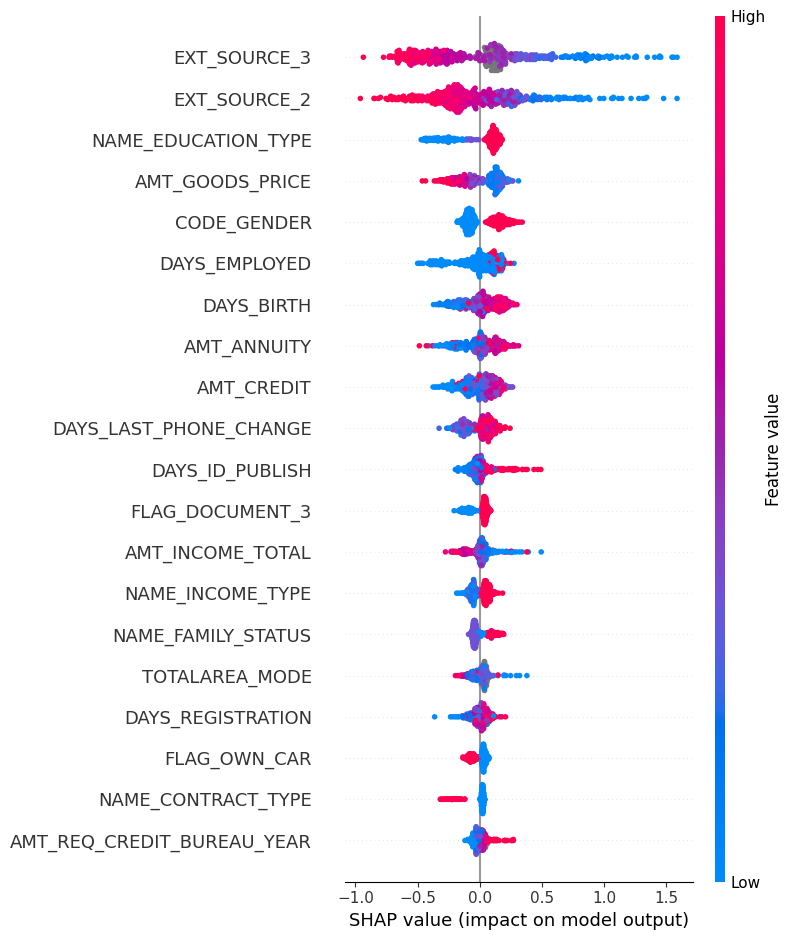

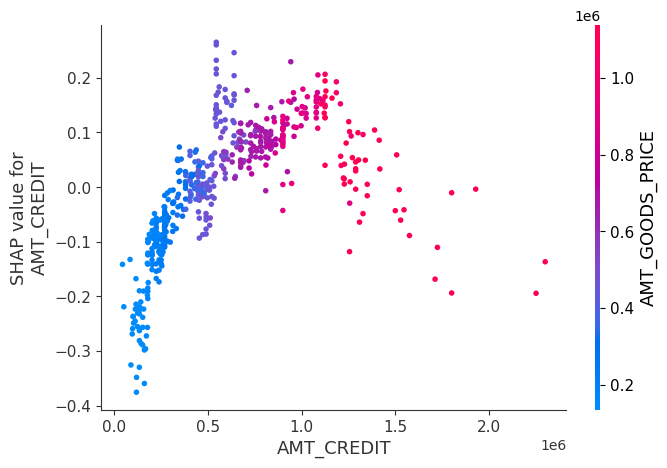

In [73]:
import shap
explainer = shap.TreeExplainer(model)
X_sample = X_valid.sample(n=min(500, X_valid.shape[0]), random_state=42)
shap_values = explainer.shap_values(X_sample)
shap.summary_plot(shap_values, X_sample)
shap.dependence_plot("AMT_CREDIT", shap_values, X_sample)


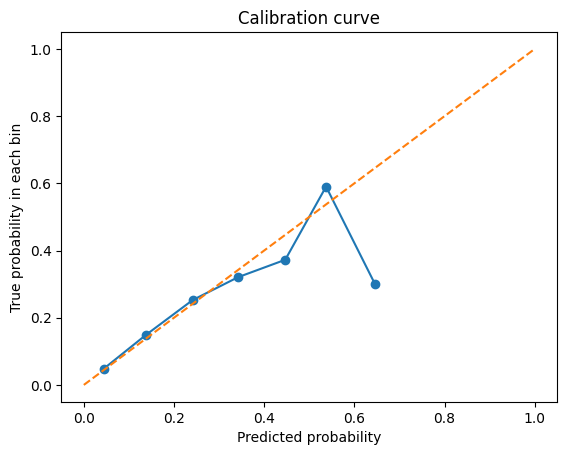

In [75]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Use out-of-fold predictions from all folds
prob_true, prob_pred = calibration_curve(y, oof_predictions, n_bins=10)

# Plot calibration curve
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("Predicted probability")
plt.ylabel("True probability in each bin")
plt.title("Calibration curve")
plt.show()
